In [94]:
import pandas as pd
import statsmodels.api as sm
import csv
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
import ssl
import pdfplumber
import urllib
from io import BytesIO
import re

## Import data

In [11]:
# COVID data -- over time

url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
covid_df = pd.read_csv(url)

In [20]:
# oil and gas employment
# https://www.bls.gov/opub/ted/2015/counties-with-highest-concentration-of-employment-in-oil-and-gas-extraction-june-2014.htm

energy_df = pd.read_csv('data/oil_gas_employment.csv')
energy_df['state'] = energy_df['County'].str[-2:]
energy_df['county'] = energy_df['County'].str[:-11]
energy_df.head()

County June14_employment  Location_quotient state  \
0  Washington County, OK             4,283              139.8    OK   
1       Upton County, TX               339              126.9    TX   
2       Woods County, OK               542               98.4    OK   
3    Crockett County, TX               217               86.9    TX   
4  Hutchinson County, TX             1,223               86.7    TX   

       county  
0  Washington  
1       Upton  
2       Woods  
3    Crockett  
4  Hutchinson

In [25]:
# county level household income
# https://txcip.org/tac/census/morecountyinfo.php?MORE=1013

income_df = pd.read_csv('data/tx_cty_income.csv')
income_df['med_income'] = income_df['median_income'].str[1:]
income_df.head()

county median_income med_income
0  Anderson       $45,969     45,969
1   Andrews       $84,946     84,946
2  Angelina       $46,653     46,653
3   Aransas       $46,912     46,912
4    Archer       $61,190     61,190

In [12]:
# county public health region
regions = pd.read_excel('data/PHR_MSA_County_masterlist.xlsx')
regions['county'] = regions['County Name']
regions.head()

County Name  FIPS #  County #  Public Health Region (11)  \
0    Anderson     1.0       1.0                        4.0   
1     Andrews     3.0       2.0                        9.0   
2    Angelina     5.0       3.0                        5.0   
3     Aransas     7.0       4.0                       11.0   
4      Archer     9.0       5.0                        2.0   

  Health Service Region (8) Metropolitan Statistical Area (MSA)  \
0                      4/5N                                  --   
1                      9/10                                  --   
2                      4/5N                                  --   
3                        11                      Corpus Christi   
4                       2/3                       Wichita Falls   

  Metropolitan Divisions (MD) Metro Area (82)  \
0                          --       Non-Metro   
1                          --       Non-Metro   
2                          --       Non-Metro   
3                          --           Metro   
4                          --           Metro   

  NCHS Urban Rural Classification (2006)  \
0                           Micropolitan   
1                           Micropolitan   
2                           Micropolitan   
3                           Medium Metro   
4                            Small Metro   

  NCHS Urban Rural Classification (2013) Border 32 (La Paz Agreement)  \
0                           Micropolitan                   Non-Border   
1                           Micropolitan                   Non-Border   
2                           Micropolitan                   Non-Border   
3                           Medium Metro                   Non-Border   
4                            Small Metro                   Non-Border   

    Border 15    county  
0  Non-Border  Anderson  
1  Non-Border   Andrews  
2  Non-Border  Angelina  
3  Non-Border   Aransas  
4  Non-Border    Archer

In [76]:
# tx prison population 11/2
# quick scrape
url = 'https://www.tcjs.state.tx.us/wp-content/uploads/2020/11/AbbreRptCurrent.pdf'
file = urllib.request.urlopen(url).read()
readfile = BytesIO(file)
pdf = pdfplumber.open(readfile)

df = pd.DataFrame()
columns = ['county', 'pretrial_felons', 'conv_felons', 'conv_felons_sentenced_cnty_jail', 'parole_violators', 'parole_violators_new_charge', 'pretrial_misd', 'conv_misd', 'bench_warrants', 'federal', 'pretrial_sjf', 'conv_sjf_sentenced_cnty_jail', 'conv_sjf_sentenced_state_jail', 'total_others', 'total_local', 'total_contract', 'total_pop', 'total_capacity', 'perc_capacity', 'available_beds']
for page in pdf.pages:
    page_num = page.page_number
    #print(page_num)
    page_text = page.extract_text()
    lines = page_text.splitlines()
    rows = []
    if page_num == 1: 
        line_start = 8 
    else: line_start = 6
    len_lines = len(lines) - 1
    for line in lines[8:len_lines]:
        #print(line)
        cnty = re.findall('\d*\D+',line)[0].strip()
        data = re.findall('\d+',line)
        if len(data) == 20:
            middle = data[0:-3]
            end = [data[-3:][0] + '.' + data[-3:][1], data[-3:][2]]
            row = [cnty] + middle + end
        if len(data) == 19:
            middle = data[0:-1]
            end = ['0'] + data[-1:]
            row = [cnty] + middle + end
            if len(row) != 20:
                cnty = cnty + ' ' + re.findall('\d*\D+',line)[1].strip()
                middle = data[1:-1]
                end = ['0'] + data[-1:]
                row = [cnty] + middle + end
        if len(data) == 21:
            cnty = cnty + ' ' + re.findall('\d*\D+',line)[1].strip()
            middle = data[1:-3]
            end = [data[-3:][0] + '.' + data[-3:][1], data[-3:][2]]
            row = [cnty] + middle + end
        #print(len(row))
        rows.append(row)
    
    temp = pd.DataFrame(rows, columns=columns)
    df = pd.concat([df, temp])
    
tx_prison = df.copy()
tx_prison.head()

county pretrial_felons conv_felons conv_felons_sentenced_cnty_jail  \
0  Anderson              94          29                               2   
1   Andrews              18           2                               0   
2  Angelina             140          11                              11   
3   Aransas              36           6                               0   
4    Archer               4           5                               0   

  parole_violators parole_violators_new_charge pretrial_misd conv_misd  \
0                3                           7            18         2   
1                3                           6             9         1   
2                5                           0            19         4   
3                3                           4             5         0   
4                1                           3             2         0   

  bench_warrants federal pretrial_sjf conv_sjf_sentenced_cnty_jail  \
0              0       0           15                            0   
1              0       0            5                            0   
2              2       0           26                            0   
3              6      71            6                            0   
4              0       0            5                            0   

  conv_sjf_sentenced_state_jail total_others total_local total_contract  \
0                             5            0         175              0   
1                             1            0          31              0   
2                             0            0         218              0   
3                             0            0          66             71   
4                             0            3          23             10   

  total_pop total_capacity perc_capacity available_beds  
0       175            300         58.33             95  
1        31             50         62.00             14  
2       218            279         78.14             33  
3       137            212         64.62             54  
4        33             48         68.75             10

In [13]:
# county fips

cnty_fips = pd.read_csv('data/us_cnty_fips.csv')
cnty_fips.head()

FIPS     Name State
0  1001  Autauga    AL
1  1003  Baldwin    AL
2  1005  Barbour    AL
3  1007     Bibb    AL
4  1009   Blount    AL

In [31]:
# cancer rates
# https://www.cancer-rates.info/tx/

cancer_df = pd.read_csv('data/Invasive-Cancer-Incidence-Rates-by-County-in-Texas-All-Sites-2013---2017.csv')
cancer_df.head()

County  Population at Risk  Cases  Crude Rate  Age-adjusted Rate  \
0       Polk              234695   1882       801.9              580.0   
1      Delta               25846    201       777.7              529.5   
2   Lampasas              102120    694       679.6              512.9   
3      Starr              317405   1406       443.0              504.3   
4  Henderson              398638   2871       720.2              495.6   

   95% Confidence Interval-Lower Limit  95% Confidence Interval-Upper Limit  
0                                552.7                                608.5  
1                                455.5                                613.2  
2                                474.1                                554.2  
3                                478.1                                531.6  
4                                476.6                                515.1

In [14]:
# 2020 general election results
# https://www.kaggle.com/unanimad/us-election-2020?select=president_county_candidate.csv

election_df = pd.read_csv('data/president_county_candidate.csv')
election_df['cnty'] = election_df['county'].str[:-7]
election_df.head()

state             county      candidate party  total_votes    won  \
0  Delaware        Kent County      Joe Biden   DEM        44552   True   
1  Delaware        Kent County   Donald Trump   REP        41009  False   
2  Delaware        Kent County   Jo Jorgensen   LIB         1044  False   
3  Delaware        Kent County  Howie Hawkins   GRN          420  False   
4  Delaware  New Castle County      Joe Biden   DEM       195034   True   

         cnty  
0        Kent  
1        Kent  
2        Kent  
3        Kent  
4  New Castle

In [41]:
# 2020 unemployment claims
# https://www.twc.texas.gov/news/unemployment-claims-numbers#claimsByCounty

ui_df = pd.read_excel('data/weekly-claims-by-county-twc.xlsx', skiprows=[0,1])
ui_df.rename(columns={'County':'county'}, inplace=True)
ui_df.head()

county  11/21/2020  11/14/2020  11/7/2020  10/31/2020  10/24/2020  \
0  Anderson        54.0        47.0       51.0        42.0        79.0   
1   Andrews        23.0        29.0       12.0        17.0        17.0   
2  Angelina       103.0        89.0       83.0        77.0        89.0   
3   Aransas        33.0        24.0       20.0        32.0        22.0   
4    Archer        10.0        16.0        5.0         3.0         6.0   

   10/17/2020  10/10/2020  10/3/2020  9/26/2020  ...  5/9/2019  5/2/2019  \
0        54.0        63.0       64.0       64.0  ...      14.0      12.0   
1        17.0        30.0       25.0       21.0  ...       6.0       1.0   
2        80.0        98.0      103.0      100.0  ...      51.0      42.0   
3        40.0        18.0       26.0       35.0  ...      21.0       2.0   
4         5.0        10.0        6.0        5.0  ...       NaN       1.0   

   4/25/2019  4/18/2019  4/11/2019  4/4/2019  3/28/2019  3/21/2019  3/14/2019  \
0       30.0       16.0       19.0      16.0       22.0       29.0       25.0   
1       12.0       11.0        7.0       5.0       12.0       19.0       19.0   
2       59.0       36.0       37.0      80.0       35.0       39.0       40.0   
3        8.0        7.0        8.0      10.0       13.0       16.0        8.0   
4       10.0        2.0        2.0       2.0        9.0        9.0        6.0   

   3/7/2019  
0      22.0  
1      30.0  
2      89.0  
3      10.0  
4      10.0  

[5 rows x 78 columns]

In [15]:
# 2020 county population 
# https://worldpopulationreview.com/us-counties/states/tx

pop_df = pd.read_csv('data/2020pop.csv')
pop_df['county'] = pop_df['CTYNAME'].str[:-7]
pop_df.head()

CTYNAME  pop2020  GrowthRate   county
0   Harris County  4767540     16.0598   Harris
1   Dallas County  2667720     12.4515   Dallas
2  Tarrant County  2139860     17.7358  Tarrant
3    Bexar County  2040460     18.4345    Bexar
4   Travis County  1290690     25.2440   Travis

In [16]:
# Age, sex, race data
# https://demographics.texas.gov/Data/TPEPP/Estimates/

demo_df = pd.read_csv('data/age_sex_race.csv')
allage_df = demo_df[(demo_df['County'] != 'STATE OF TEXAS') & (demo_df['Age'] == 'All Ages')]
allage_df['cnty'] = allage_df['County'].str[:-7]
allage_df = allage_df[['cnty', 'FIPS', 'Total', 'Total_Male', 'Total_Female', 'NH_White_Total', 'NH_Black_Total', 
                    'NH_Asian_Total', 'NH_Other_Total', 'Hispanic_Total']]
allage_df.head()

/Users/madeline.campbell/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


cnty  FIPS  Total  Total_Male  Total_Female  NH_White_Total  \
97   ANDERSON     1  59025       36468         22557           34133   
194   ANDREWS     3  19279        9883          9396            6767   
291  ANGELINA     5  90989       44735         46254           54355   
388   ARANSAS     7  23710       11863         11847           15566   
485    ARCHER     9   9228        4546          4682            7917   

     NH_Black_Total  NH_Asian_Total  NH_Other_Total  Hispanic_Total  
97            12495             315            1374           10708  
194             222              85             228           11977  
291           13650             919            1489           20576  
388             242             408             458            7036  
485              57              25             264             965

## Compare election results to COVID case / death counts 

In [17]:
covid_tx = covid_df[(covid_df.state == 'Texas') & (covid_df.date == '2020-11-03')]

# append population data
covid_pop = covid_tx.merge(pop_df[['county', 'pop2020']], how='outer', on='county')

# pop weighted covid metrics
covid_pop['pop2020_10k'] = covid_pop.pop2020 / 10000
covid_pop['cases_10k'] = covid_pop.cases / covid_pop.pop2020_10k
covid_pop['deaths_10k'] = covid_pop.deaths / covid_pop.pop2020_10k
covid_pop.head()

date    county  state     fips   cases  deaths  pop2020  pop2020_10k  \
0  2020-11-03  Anderson  Texas  48001.0  2987.0    39.0    57747       5.7747   
1  2020-11-03   Andrews  Texas  48003.0   667.0    10.0    19122       1.9122   
2  2020-11-03  Angelina  Texas  48005.0  2966.0    93.0    85854       8.5854   
3  2020-11-03   Aransas  Texas  48007.0   351.0    18.0    20482       2.0482   
4  2020-11-03    Archer  Texas  48009.0   170.0     1.0     8786       0.8786   

    cases_10k  deaths_10k  
0  517.256308    6.753598  
1  348.812886    5.229578  
2  345.470217   10.832343  
3  171.369983    8.788204  
4  193.489643    1.138174

In [57]:
election_df.head()

state             county      candidate party  total_votes    won  \
0  Delaware        Kent County      Joe Biden   DEM        44552   True   
1  Delaware        Kent County   Donald Trump   REP        41009  False   
2  Delaware        Kent County   Jo Jorgensen   LIB         1044  False   
3  Delaware        Kent County  Howie Hawkins   GRN          420  False   
4  Delaware  New Castle County      Joe Biden   DEM       195034   True   

         cnty  
0        Kent  
1        Kent  
2        Kent  
3        Kent  
4  New Castle

In [71]:
e_lim = election_df[['state', 'cnty', 'candidate', 'total_votes']][election_df['candidate'].isin(['Joe Biden', 'Donald Trump', 'Jo Jorgensen', 'Howie Hawkins'])]
e_pivot = pd.pivot_table(e_lim, index=['state', 'cnty'], columns=['candidate'], values='total_votes').reset_index()
e_pivot.rename(columns={'cnty':'county'}, inplace=True)
e_pivot['total_4way'] = e_pivot.iloc[:, -4:].sum(axis=1)
e_pivot['total_2way'] = e_pivot['Donald Trump'] + e_pivot['Joe Biden']
e_pivot['third_party'] = e_pivot['Jo Jorgensen'] + e_pivot['Howie Hawkins']
e_pivot['p_trump'] = (e_pivot['Donald Trump'] / e_pivot['total_2way'])*100
e_pivot['p_biden'] = (e_pivot['Joe Biden'] / e_pivot['total_2way'])*100
e_pivot.head()

candidate    state   county  Donald Trump  Howie Hawkins  Jo Jorgensen  \
0          Alabama  Autauga       19764.0            NaN         346.0   
1          Alabama  Baldwin       83055.0            NaN        1221.0   
2          Alabama  Barbour        5605.0            NaN          68.0   
3          Alabama     Bibb        7508.0            NaN          73.0   
4          Alabama   Blount       24595.0            NaN         209.0   

candidate  Joe Biden  total_4way  total_2way  third_party    p_trump  \
0             7450.0     27560.0     27214.0          NaN  72.624385   
1            24344.0    108620.0    107399.0          NaN  77.333122   
2             4772.0     10445.0     10377.0          NaN  54.013684   
3             1982.0      9563.0      9490.0          NaN  79.114858   
4             2627.0     27431.0     27222.0          NaN  90.349717   

candidate    p_biden  
0          27.375615  
1          22.666878  
2          45.986316  
3          20.885142  
4           9.650283

In [75]:
e_texas = e_pivot[e_pivot['state'] == 'Texas'].drop(['state'], axis=1)

In [76]:
t_merge = covid_pop.merge(e_texas, how='outer', on='county')

In [77]:
t_merge.head()

date    county  state     fips   cases  deaths  pop2020  pop2020_10k  \
0  2020-11-03  Anderson  Texas  48001.0  2987.0    39.0    57747       5.7747   
1  2020-11-03   Andrews  Texas  48003.0   667.0    10.0    19122       1.9122   
2  2020-11-03  Angelina  Texas  48005.0  2966.0    93.0    85854       8.5854   
3  2020-11-03   Aransas  Texas  48007.0   351.0    18.0    20482       2.0482   
4  2020-11-03    Archer  Texas  48009.0   170.0     1.0     8786       0.8786   

    cases_10k  deaths_10k  Donald Trump  Howie Hawkins  Jo Jorgensen  \
0  517.256308    6.753598       15062.0           22.0         132.0   
1  348.812886    5.229578        4937.0           10.0          60.0   
2  345.470217   10.832343       25070.0           75.0         273.0   
3  171.369983    8.788204        9210.0           31.0         103.0   
4  193.489643    1.138174        4300.0            4.0          45.0   

   Joe Biden  total_4way  total_2way  third_party    p_trump    p_biden  
0     3934.0     19150.0     18996.0        154.0  79.290377  20.709623  
1      849.0      5856.0      5786.0         70.0  85.326651  14.673349  
2     9136.0     34554.0     34206.0        348.0  73.291235  26.708765  
3     2896.0     12240.0     12106.0        134.0  76.077978  23.922022  
4      446.0      4795.0      4746.0         49.0  90.602613   9.397387

## TX COVID county by county

In [18]:
tx_covid = covid_df[covid_df.state == 'Texas']
tx_covid = tx_covid.merge(pop_df[['county', 'pop2020']], how='outer', on='county')

# pop weighted covid metrics
tx_covid['pop2020_10k'] = tx_covid.pop2020 / 10000
tx_covid['cases_10k'] = tx_covid.cases / tx_covid.pop2020_10k
tx_covid['deaths_10k'] = tx_covid.deaths / tx_covid.pop2020_10k
tx_covid['dt'] = tx_covid['date'].str[5:]
#tx_covid.head()

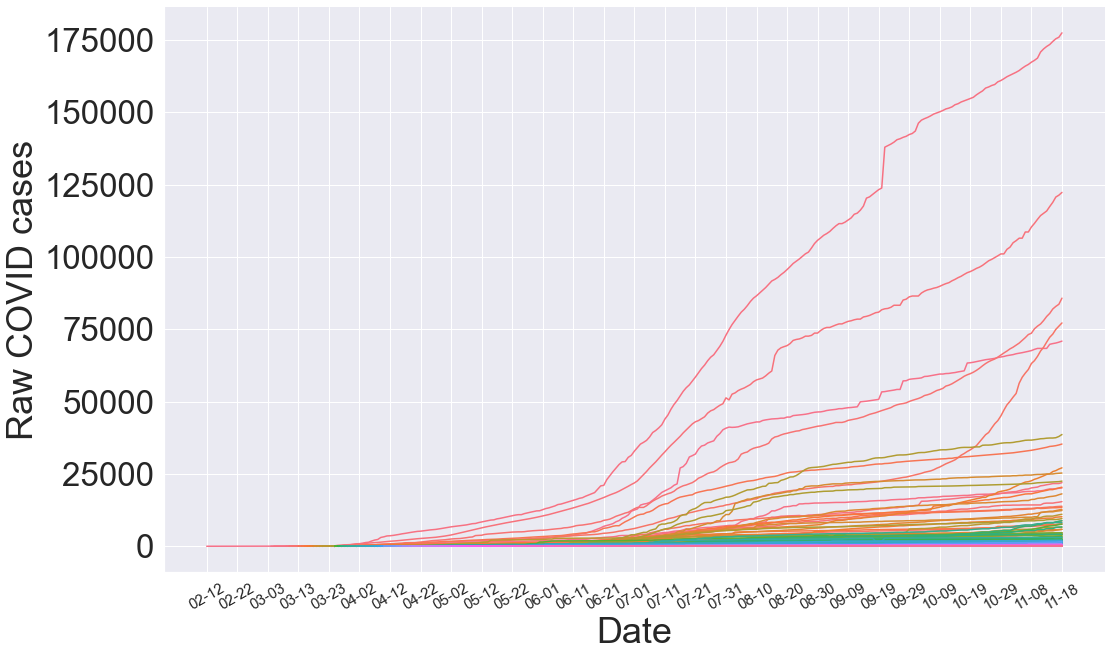

In [303]:
# make plot
sns.set(font_scale=3)

# fav_lim = fav_m[(~fav_m['state_code'].isin(['CO', 'OH', 'ME', 'IA'])) & (~fav_m['fav'].isin(['3-Undecided/Neither/Other', 'Biden_DK_NoOpinion', 'Trump_DK_NoOpinion']))]
# plt.figure(figsize=(10,5))
# fav_m.sort_values(by=['date', 'fav'], inplace=True)
# d = {'color': ['b', 'r', 'navy', 'navy', 'maroon', 'maroon'], "ls" : ["-","-",":", "--",":", "--"]}
g = sns.FacetGrid(tx_covid.sort_values(by=['dt', 'county']), 
                  hue='county', height=10, legend_out=True) 
# hue_kws=d, col='state_code', col_wrap=2) 
g = (g.map(sns.lineplot, "dt", "cases"))
g.fig.set_size_inches(20,10)
g.set_xticklabels(size = 15, step=10, rotation=30)
g.set_axis_labels('Date', 'Raw COVID cases')
#g.add_legend()

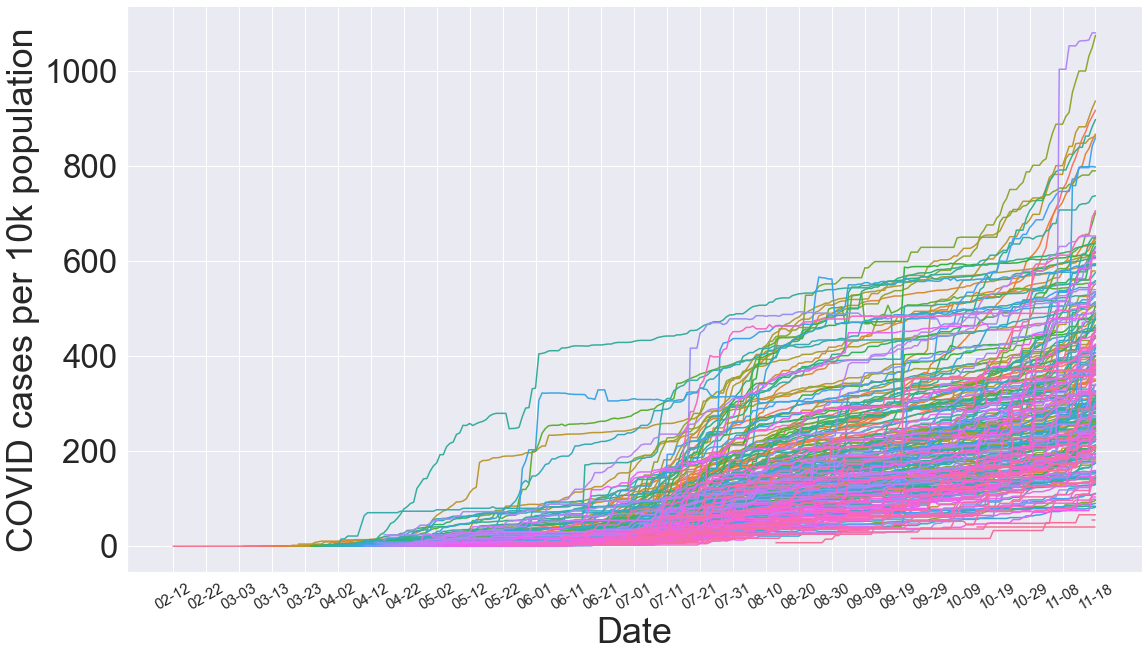

In [302]:
# make plot
sns.set(font_scale=3)

# fav_lim = fav_m[(~fav_m['state_code'].isin(['CO', 'OH', 'ME', 'IA'])) & (~fav_m['fav'].isin(['3-Undecided/Neither/Other', 'Biden_DK_NoOpinion', 'Trump_DK_NoOpinion']))]
# plt.figure(figsize=(10,5))
# fav_m.sort_values(by=['date', 'fav'], inplace=True)
# d = {'color': ['b', 'r', 'navy', 'navy', 'maroon', 'maroon'], "ls" : ["-","-",":", "--",":", "--"]}
g = sns.FacetGrid(tx_covid.sort_values(by=['dt', 'county']), 
                  hue='county', height=10, legend_out=True) 
# hue_kws=d, col='state_code', col_wrap=2) 
g = (g.map(sns.lineplot, "dt", "cases_10k"))
g.fig.set_size_inches(20,10)
g.set_xticklabels(size = 15, step=10, rotation=30)
g.set_axis_labels('Date', 'COVID cases per 10k population')
#g.add_legend()

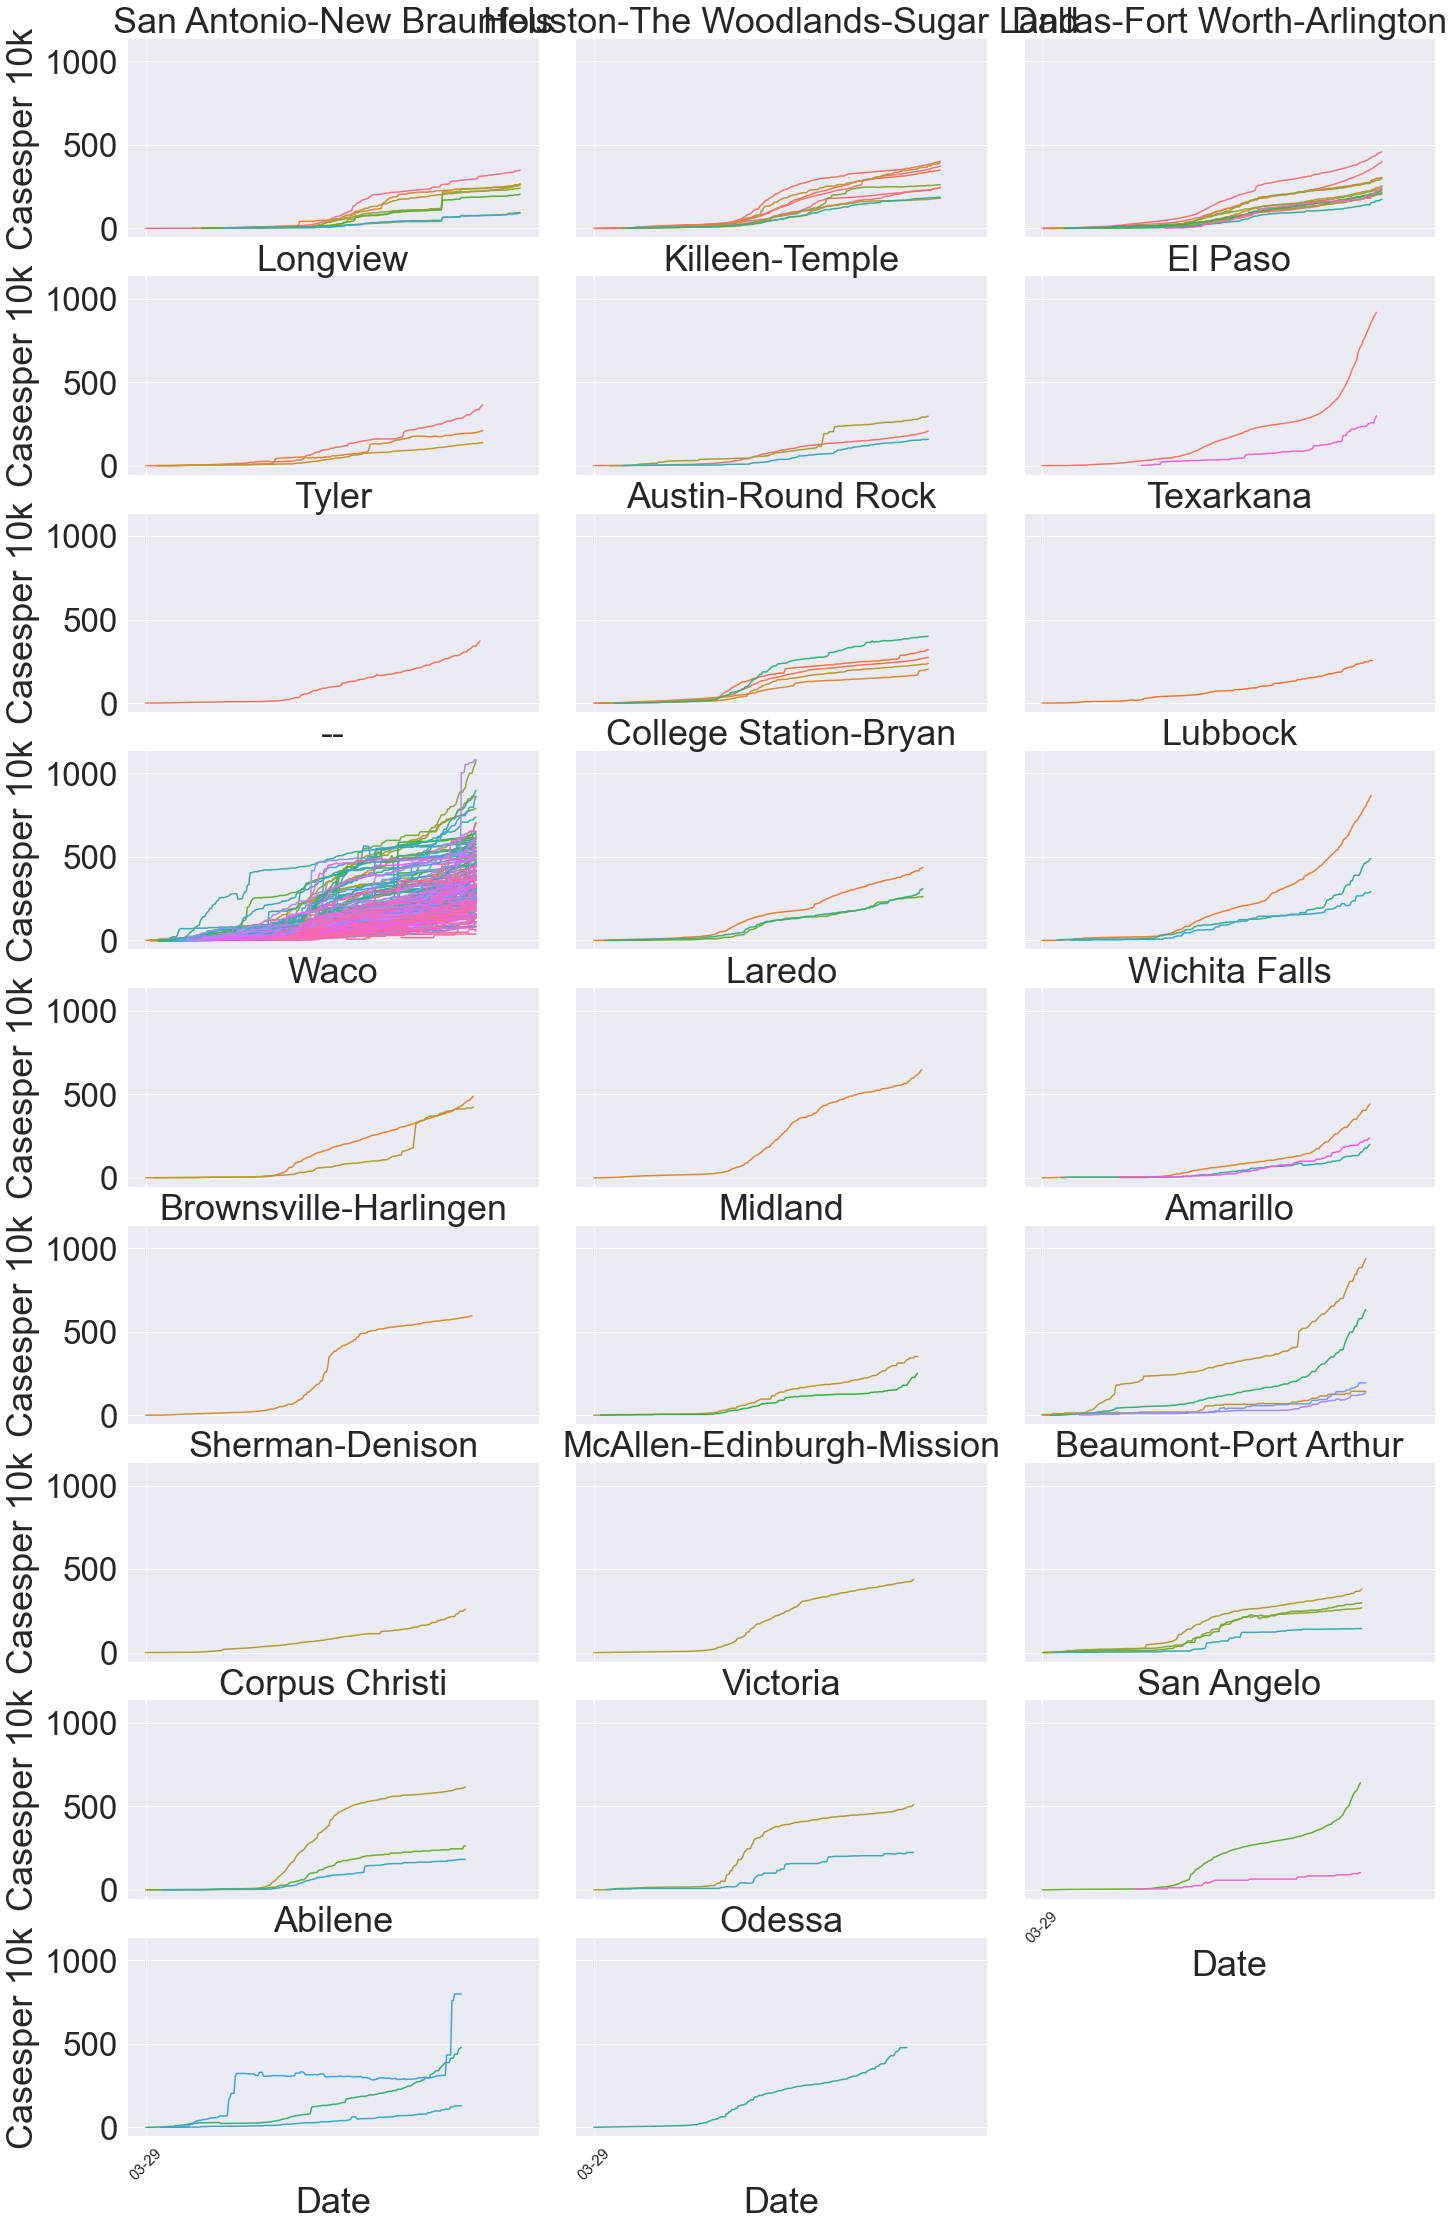

In [312]:
# Facet by MSA 
# merge on public health region data
tx_covid_reg = tx_covid.merge(regions, how='outer', on='county')
tx_covid_reg.head()

data = tx_covid_reg.sort_values(by=['dt', 'county']) # [~tx_covid_reg['Metropolitan Statistical Area (MSA)'].isin(['--', 'na'])]
sns.set(font_scale=3)
g = sns.FacetGrid(data, 
                  hue='county', height=10, legend_out=True, 
                  col='Metropolitan Statistical Area (MSA)', col_wrap=3) 
g = (g.map(sns.lineplot, "dt", "cases_10k"))
g.fig.set_size_inches(20,30)
g.set_xticklabels(size = 15, step=10, rotation=45)
g.set_axis_labels('Date', 'Casesper 10k')
g.set_titles(col_template = '{col_name}')
# g.add_legend()

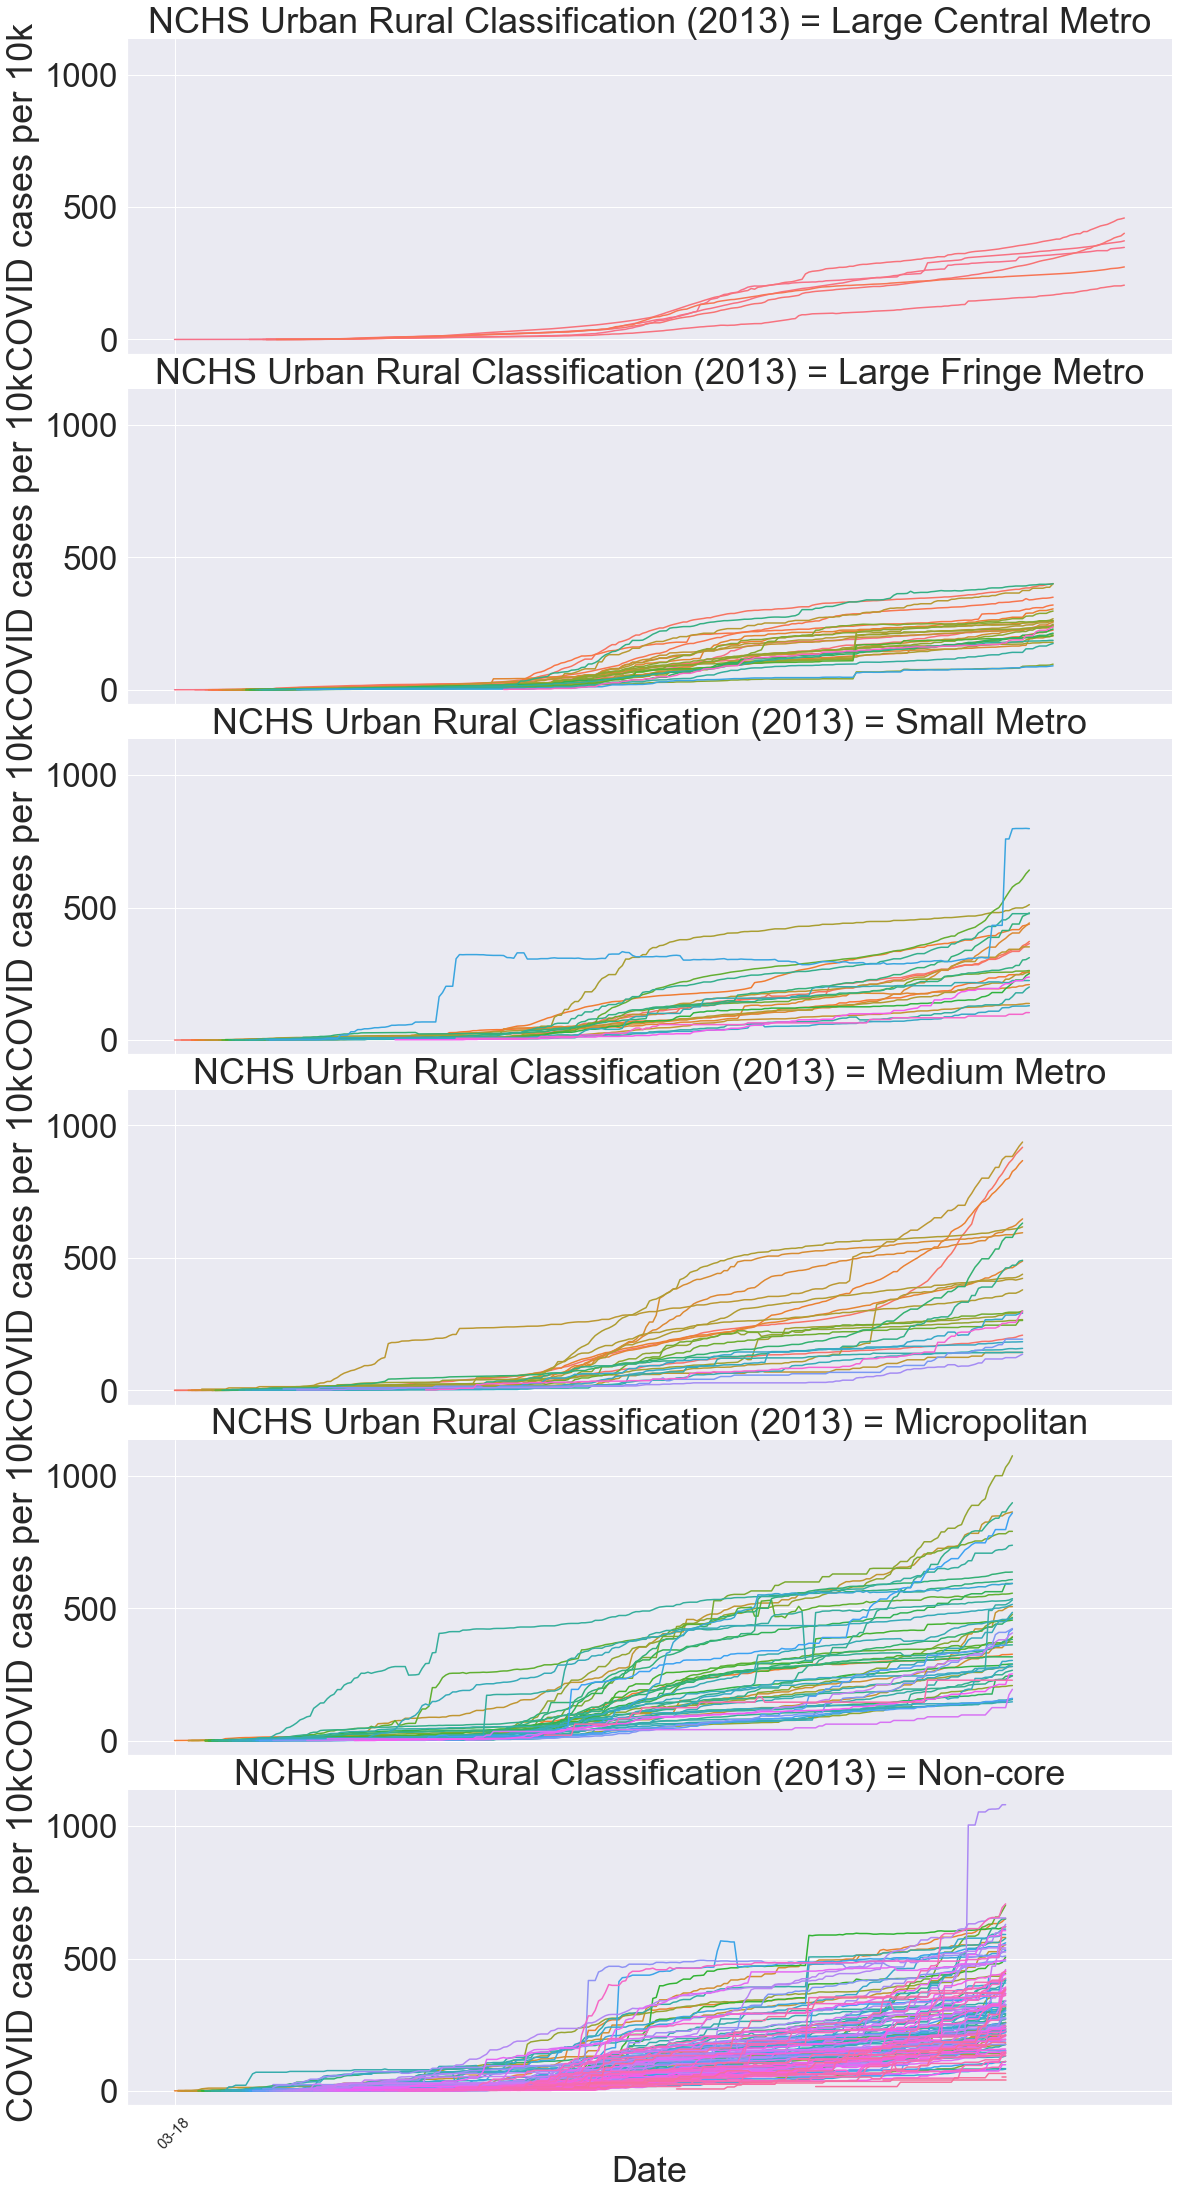

In [307]:
# Facet by Urban Rural Classification
# merge on public health region data
data = tx_covid_reg.sort_values(by=['dt', 'county']) # [~tx_covid_reg['Metropolitan Statistical Area (MSA)'].isin(['--', 'na'])]
sns.set(font_scale=3)
g = sns.FacetGrid(data, 
                  hue='county', height=10, legend_out=True, 
                  col='NCHS Urban Rural Classification (2013)', col_wrap=1) 
g = (g.map(sns.lineplot, "dt", "cases_10k"))
g.fig.set_size_inches(20,30)
g.set_xticklabels(size = 15, step=10, rotation=45)
g.set_axis_labels('Date', 'COVID cases per 10k')
# g.add_legend()

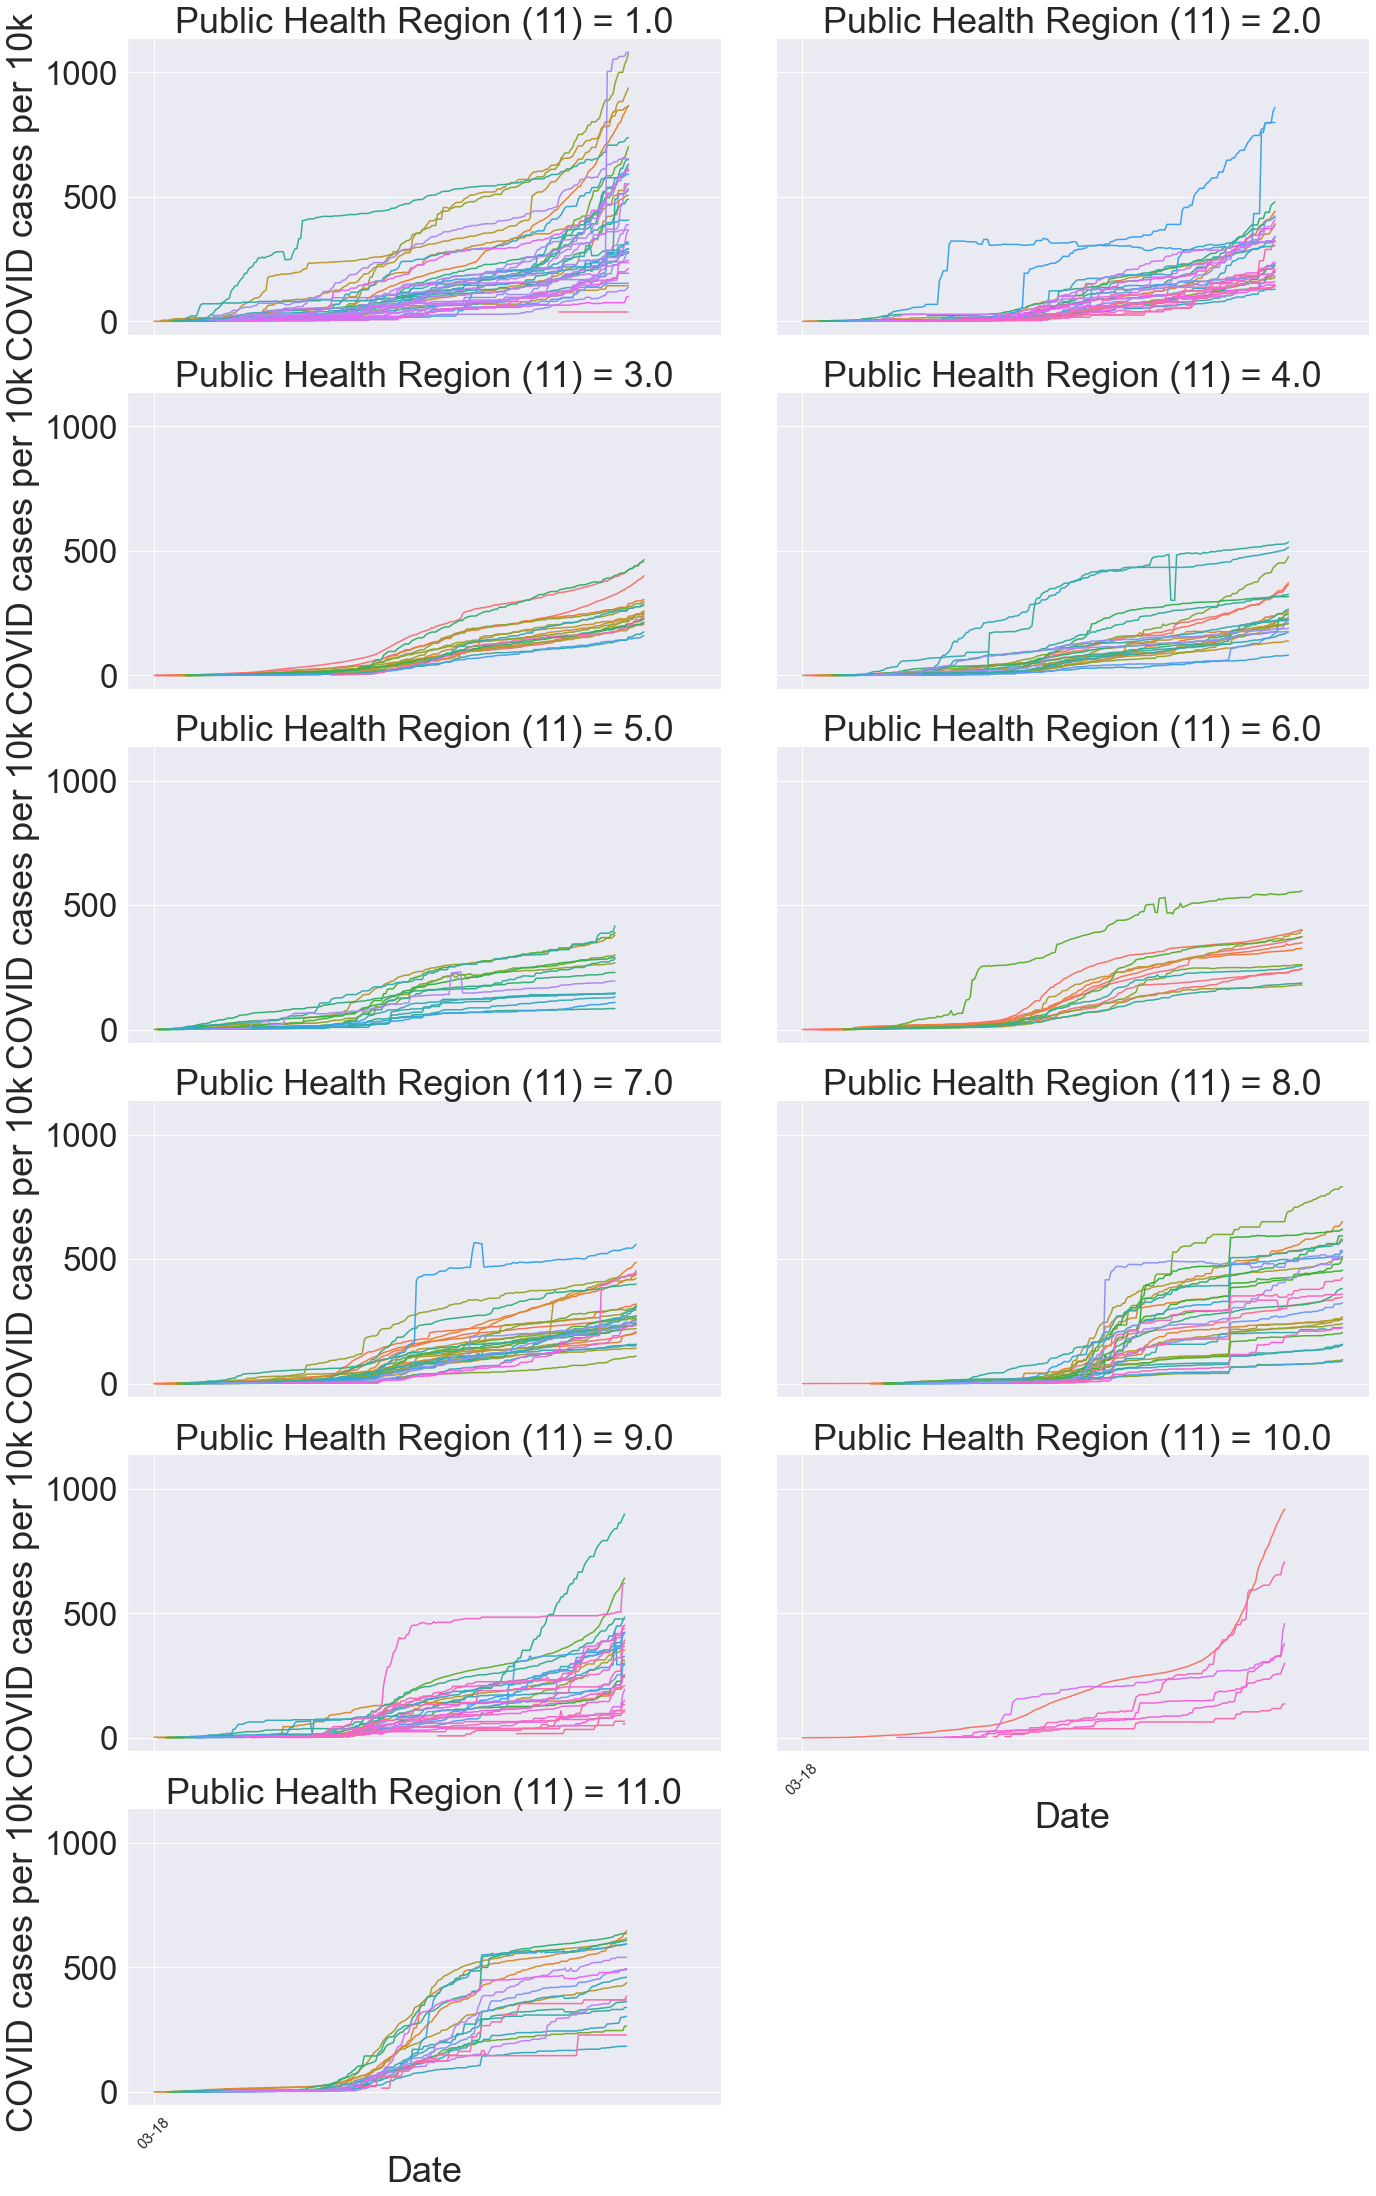

In [309]:
# Facet by Public Health Region
# merge on public health region data
data = tx_covid_reg.sort_values(by=['dt', 'county']) # [~tx_covid_reg['Metropolitan Statistical Area (MSA)'].isin(['--', 'na'])]
sns.set(font_scale=3)
g = sns.FacetGrid(data, 
                  hue='county', height=10, legend_out=True, 
                  col='Public Health Region (11)', col_wrap=2) 
g = (g.map(sns.lineplot, "dt", "cases_10k"))
g.fig.set_size_inches(20,30)
g.set_xticklabels(size = 15, step=10, rotation=45)
g.set_axis_labels('Date', 'COVID cases per 10k')
# g.add_legend()

In [115]:
from bokeh.io import show
from bokeh.models import LogColorMapper, ColorBar, LogTicker, ColumnDataSource
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import YlOrBr6 as palette #Reds256 as palette
import bokeh
#bokeh.sampledata.download()
from bokeh.sampledata.unemployment import data as unemployment
from bokeh.sampledata.us_counties import data as counties
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import output_notebook

# Make bokeh show plot in jupyter notebook
output_notebook() 
import pyproj

Loading BokehJS ...

In [116]:
palette = tuple(reversed(palette))

counties = {
    code: county for code, county in counties.items() if county["state"] == "tx"
}

county_xs = [county["lons"] for county in counties.values()]
county_ys = [county["lats"] for county in counties.values()]

county_names = [county['name'] for county in counties.values()]
county_rates = [unemployment[county_id] for county_id in counties]
color_mapper = LogColorMapper(palette=palette)

temp = tx_covid[tx_covid.date == '2020-11-03'].sort_values(by='county')

data=dict(
    x=county_xs,
    y=county_ys,
    name=temp.county,
    cases=temp.cases_10k,
)

TOOLS = "pan,wheel_zoom,reset,hover,save"

# # Transforming coordinates
# project_projection = pyproj.Proj("+init=EPSG:4326")  # wgs84
# google_projection = pyproj.Proj("+init=EPSG:3857")  # default google projection
# x, y = pyproj.transform(project_projection, google_projection, county_xs, county_ys)

p = figure(
    title="COVID cases per 10k pop, 11/3", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,
    tooltips=[
        ("Name", "@name"), ("Cases per 10k", "@cases"), ("(Long, Lat)", "($x, $y)")
    ])
p.grid.grid_line_color = None
p.hover.point_policy = "follow_mouse"

p.patches('x', 'y', source=data,
          fill_color={'field': 'cases', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

show(p)

## unemployment

In [52]:
cols = ['county','11/21/2020','11/14/2020','11/7/2020','10/31/2020', '10/24/2020', '10/17/2020','10/10/2020', '10/3/2020', '9/26/2020','9/19/2020', '9/12/2020','9/5/2020', '8/29/2020','8/22/2020', '8/15/2020','8/8/2020', '8/1/2020','7/25/2020', '7/18/2020','7/11/2020', '7/4/2020','6/27/2020', '6/20/2020','6/13/2020', '6/6/2020','5/30/2020', '5/23/2020','5/16/2020', '5/9/2020','5/2/2020', '4/25/2020','4/18/2020', '4/11/2020','4/4/2020', '3/28/2020','3/21/2020', '3/14/2020','3/7/2020']
ui_2020 = ui_df[cols]
ui_2020p = pd.melt(ui_2020, id_vars=['county'], value_vars=cols[1:])
ui_2020p.head()

county    variable  value
0  Anderson  11/21/2020   54.0
1   Andrews  11/21/2020   23.0
2  Angelina  11/21/2020  103.0
3   Aransas  11/21/2020   33.0
4    Archer  11/21/2020   10.0

In [55]:
# sum unemp since march
ui_grp = ui_2020p.groupby(['county'])['value'].sum().reset_index()
ui_pop = ui_grp.merge(pop_df[['county', 'pop2020']], how='outer', on='county')
ui_pop['pop2020_10k'] = ui_pop.pop2020 / 10000
ui_pop['ui_10k'] = ui_pop.value / ui_pop.pop2020_10k
ui_pop.head()

county   value  pop2020  pop2020_10k       ui_10k
0  Anderson  4003.0  57747.0       5.7747   693.196183
1   Andrews  2047.0  19122.0       1.9122  1070.494718
2  Angelina  8122.0  85854.0       8.5854   946.024646
3   Aransas  2584.0  20482.0       2.0482  1261.595547
4    Archer   566.0   8786.0       0.8786   644.206692

In [64]:
# does the number of unemployment cases filed since march by population map to cases by population? 
covid_temp = tx_covid[tx_covid.dt == tx_covid.dt.max()][['county', 'cases', 'deaths', 'cases_10k', 'deaths_10k']]
cov_ui = ui_pop.merge(covid_temp, how='outer', on='county')
cov_ui_reg = cov_ui.merge(regions, how='outer', on='county')
cov_ui_reg.head()

county   value  pop2020  pop2020_10k       ui_10k   cases  deaths  \
0  Anderson  4003.0  57747.0       5.7747   693.196183  3190.0    49.0   
1   Andrews  2047.0  19122.0       1.9122  1070.494718  1066.0    13.0   
2  Angelina  8122.0  85854.0       8.5854   946.024646  3696.0    99.0   
3   Aransas  2584.0  20482.0       2.0482  1261.595547   438.0    19.0   
4    Archer   566.0   8786.0       0.8786   644.206692   260.0     2.0   

    cases_10k  deaths_10k County Name  ...  County #  \
0  552.409649    8.485289    Anderson  ...       1.0   
1  557.473068    6.798452     Andrews  ...       2.0   
2  430.498288   11.531204    Angelina  ...       3.0   
3  213.846304    9.276438     Aransas  ...       4.0   
4  295.925336    2.276349      Archer  ...       5.0   

   Public Health Region (11)  Health Service Region (8)  \
0                        4.0                       4/5N   
1                        9.0                       9/10   
2                        5.0                       4/5N   
3                       11.0                         11   
4                        2.0                        2/3   

  Metropolitan Statistical Area (MSA) Metropolitan Divisions (MD)  \
0                                  --                          --   
1                                  --                          --   
2                                  --                          --   
3                      Corpus Christi                          --   
4                       Wichita Falls                          --   

  Metro Area (82) NCHS Urban Rural Classification (2006)  \
0       Non-Metro                           Micropolitan   
1       Non-Metro                           Micropolitan   
2       Non-Metro                           Micropolitan   
3           Metro                           Medium Metro   
4           Metro                            Small Metro   

  NCHS Urban Rural Classification (2013) Border 32 (La Paz Agreement)  \
0                           Micropolitan                   Non-Border   
1                           Micropolitan                   Non-Border   
2                           Micropolitan                   Non-Border   
3                           Medium Metro                   Non-Border   
4                            Small Metro                   Non-Border   

    Border 15  
0  Non-Border  
1  Non-Border  
2  Non-Border  
3  Non-Border  
4  Non-Border  

[5 rows x 21 columns]

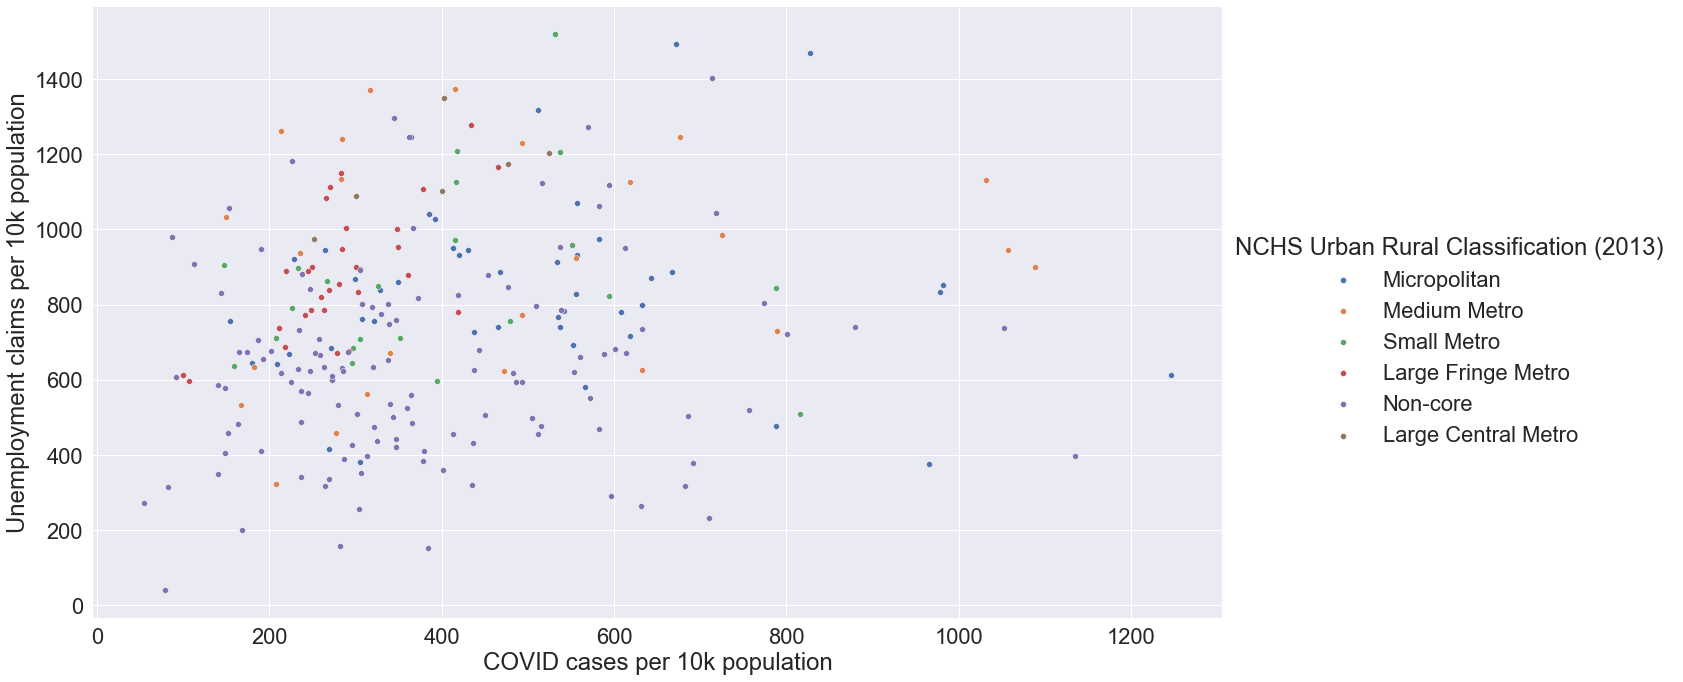

In [71]:
# make plot
sns.set(font_scale=2)

g = sns.FacetGrid(cov_ui_reg, height=10, legend_out=True, 
                 hue='NCHS Urban Rural Classification (2013)') 
# hue_kws=d, col='state_code', col_wrap=2) 
g = (g.map(sns.scatterplot, "cases_10k", "ui_10k"))
g.fig.set_size_inches(20,10)
#g.set_xticklabels(size = 15, step=10, rotation=30)
g.set_axis_labels('COVID cases per 10k population', 'Unemployment claims per 10k population')
g.add_legend()

## prison pop

In [85]:
tx_prison_lim = tx_prison[['county', 'total_pop', 'total_capacity', 'perc_capacity']]
tx_prison_lim['perc_capacity'] = tx_prison_lim['perc_capacity'].astype(float)
tx_prison_lim['total_capacity'] = tx_prison_lim['total_capacity'].astype(float)
tx_prison_lim['total_pop'] = tx_prison_lim['total_pop'].astype(float)

covid_temp = tx_covid[tx_covid.dt == tx_covid.dt.max()][['county', 'cases', 'deaths', 'pop2020', 'pop2020_10k', 'cases_10k', 'deaths_10k']]
prison_covid = tx_prison_lim.merge(covid_temp, how='outer', on='county')
prison_covid['total_pop_10k'] = prison_covid['total_pop'] / prison_covid['pop2020_10k']
prison_covid.head()

/Users/madeline.campbell/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/madeline.campbell/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/madeline.campbell/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is try

county  total_pop  total_capacity  perc_capacity   cases  deaths  \
0  Anderson      175.0           300.0          58.33  3190.0    49.0   
1   Andrews       31.0            50.0          62.00  1066.0    13.0   
2  Angelina      218.0           279.0          78.14  3696.0    99.0   
3   Aransas      137.0           212.0          64.62   438.0    19.0   
4    Archer       33.0            48.0          68.75   260.0     2.0   

   pop2020  pop2020_10k   cases_10k  deaths_10k  total_pop_10k  
0  57747.0       5.7747  552.409649    8.485289      30.304605  
1  19122.0       1.9122  557.473068    6.798452      16.211693  
2  85854.0       8.5854  430.498288   11.531204      25.391944  
3  20482.0       2.0482  213.846304    9.276438      66.887999  
4   8786.0       0.8786  295.925336    2.276349      37.559754

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

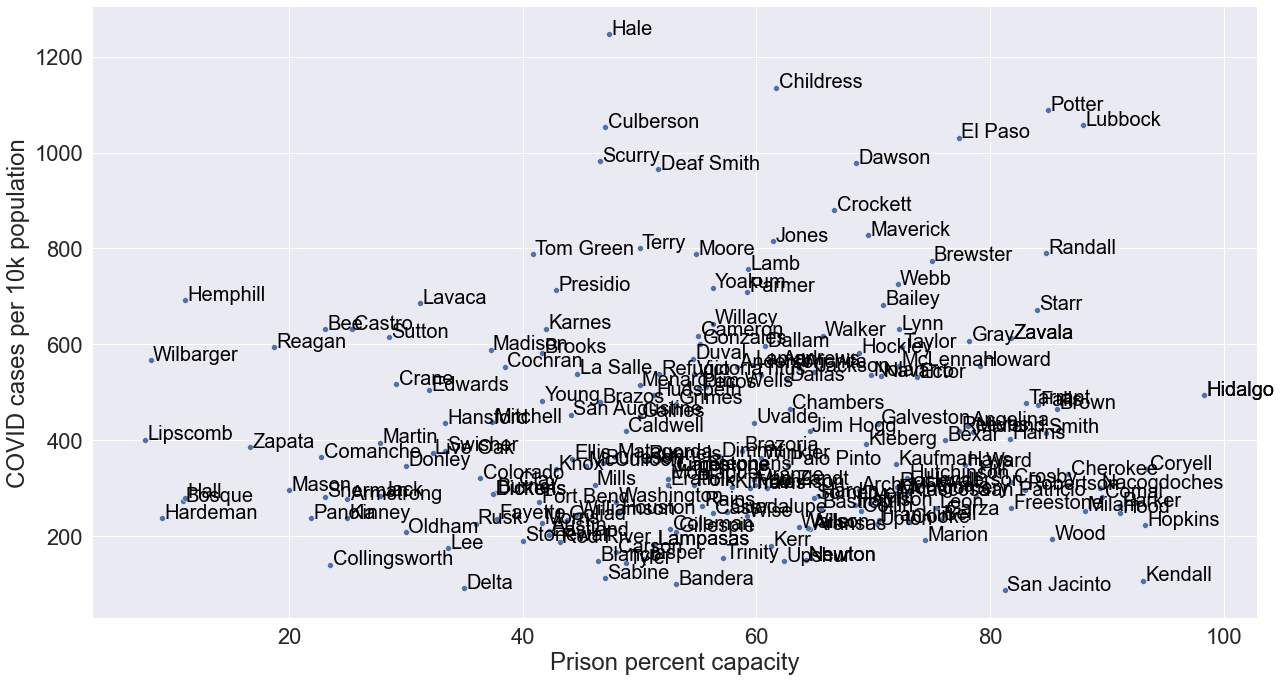

In [105]:
# make plot
sns.set(font_scale=2)
p_lim = prison_covid[prison_covid.perc_capacity != 0].reset_index()
g = sns.FacetGrid(p_lim, height=10, legend_out=True) 
#hue='NCHS Urban Rural Classification (2013)') 
# hue_kws=d, col='state_code', col_wrap=2) 
g = (g.map(sns.scatterplot, "perc_capacity", "cases_10k"))
g.fig.set_size_inches(20,10)
#g.set_xticklabels(size = 15, step=10, rotation=30)
g.set_axis_labels('Prison percent capacity', 'COVID cases per 10k population')
# add annotations one by one with a loop
for ax in g.axes.flat:
#     ax.set_title(title)
#     ax.text(0.85, 0.85,'Text Here', fontsize=9)
    for line in range(0,p_lim.shape[0]):
        ax.text(p_lim.perc_capacity[line]+0.2, p_lim.cases_10k[line], p_lim.county[line], horizontalalignment='left', size='small', color='black', weight='normal')
#g.add_legend()

In [107]:
# R^2 = 0.717
# coef = 6.6222
df_lim = p_lim[['perc_capacity', 'cases_10k']].dropna()
y = df_lim['cases_10k']
X = df_lim['perc_capacity']
model = sm.OLS(y, X)
results = model.fit()
#print(results.summary())

In [140]:
## mapping prisons in TX

# Reading our data
tx_prison_loc = pd.read_csv('data/tx_prisons.csv')
tx_prison_loc.drop('Unnamed: 0', inplace = True, axis = 1)
tx_prison_loc['color'] = 'blue'
tx_prison_loc.loc[tx_prison_loc.type == 'local_jail', 'color'] = 'yellow'
tx_prison_loc.loc[tx_prison_loc.type == 'state_pris', 'color'] = 'red'

tx_prison_loc.head()

lon        lat                           NAME        type  inmates  \
0 -95.803765  31.890961  Montalba-Tennessee Colony CCD  state_pris    11854   
1 -95.388741  29.801413                    Houston CCD  local_jail     9667   
2 -97.701935  31.432908                 Gatesville CCD  state_pris     8082   
3 -95.488876  29.240192                   Angleton CCD  state_pris     7339   
4 -95.665580  30.705037                 Huntsville CCD  state_pris     7232   

    color  
0     red  
1  yellow  
2     red  
3     red  
4     red

In [141]:
set(tx_prison_loc.type)

{'fed_pris', 'local_jail', 'state_pris'}

In [142]:
# Preparing coordinates
lat = tx_prison_loc['lat'].values
lon = tx_prison_loc['lon'].values

# Transforming coordinates
project_projection = pyproj.Proj("+init=EPSG:4326")  # wgs84
google_projection = pyproj.Proj("+init=EPSG:3857")  # default google projection
x, y = pyproj.transform(project_projection, google_projection, lon, lat)

# Plotting data
p = figure(x_range=(-11000000, -10000000), y_range=(2500000, 5000000),
            plot_width=800, plot_height=500, x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(get_provider(Vendors.CARTODBPOSITRON_RETINA))
p.circle(x=x, y=y, size=3, fill_color=tx_prison_loc['color'].values)
show(p)